In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate

%matplotlib widget


In [14]:
#Load df of simulated data
directory   = './moveAnt_vs_modeStir/data_gitignore/40_310MHz_500Q_moveAnt_18pos_3wallDrive_steelWalls_10_8_23/' #include trailing `/`


df_comsol = np.load(directory + 'dataDf.npy', allow_pickle=True)
df_comsol

,positionIdx,freq(MHz),Ex_near,Ey_near,Ez_near,Enorm_near,Ex_all,Ey_all,Ez_all,Enorm_all,LPV,s11
0,0,40.000000,0.622485,1.069996,0.751014,1.495096,0.648414,0.677096,0.646404,1.195279,0.153183,0.999970
1,0,40.080002,0.622485,1.069996,0.751014,1.495096,0.648414,0.677096,0.646404,1.195279,0.153183,0.999970
2,0,40.160000,0.622485,1.069996,0.751014,1.495096,0.648414,0.677096,0.646404,1.195279,0.153183,0.999969
3,0,40.240002,0.622485,1.069996,0.751014,1.495096,0.648414,0.677096,0.646404,1.195279,0.153183,0.999969
4,0,40.320999,0.622485,1.069996,0.751014,1.495096,0.648414,0.677096,0.646404,1.195279,0.153183,0.999968
...,...,...,...,...,...,...,...,...,...,...,...,...
18463,17,307.612000,39.170479,12.002538,32.207817,55.924423,31.140749,13.869156,35.924980,52.330589,4.309466,0.698746
18464,17,308.227997,23.809851,19.963230,18.973083,39.374134,18.308559,15.750480,21.750729,36.250748,1.715535,0.586095
18465,17,308.843994,17.787285,13.663861,22.248446,33.732182,21.868002,7.615380,25.229118,35.925175,2.074518,0.622723
18466,17,309.462006,13.672132,13.680718,15.211812,25.982218,15.533454,7.776422,15.336432,25.544699,0.778493,0.309704


In [15]:
#pack df of measured data from CSVs

import os
import pandas as pd

# Directory containing the CSV files
data_dir_new = '/drBigBoy/darkRadio/VNA/QTesting/Bicon-314-30positions-30Oct2023/'

# List of file indices to ignore
bad_data_idx = [3, 7, 12, 14, 15, 18,19, 24]

# Columns to extract from the CSV
columns_to_extract = ['Frequency', 'S11_Magnitude', 'S11_Phase']

# Initialize an empty DataFrame to hold the data
df_meas = pd.DataFrame()

# List all files in the directory that match the pattern and are not in the bad data index
for filename in os.listdir(data_dir_new):
    if filename.startswith('Bicon-S11-314-p') and filename.endswith('.csv'):
        # Extract index from the filename and check if it's not in the bad data list
        file_idx = int(filename.split('p')[-1].split('.')[0])  # Extract the number after 'p'
        if file_idx not in bad_data_idx:
            # Construct full file path
            file_path = os.path.join(data_dir_new, filename)
            # Read the CSV file
            temp_df = pd.read_csv(file_path, usecols=columns_to_extract)
            # Add the index column
            temp_df['Index'] = file_idx
            # Append to the main DataFrame
            df_meas = pd.concat([df_meas, temp_df], ignore_index=True)

df_meas['S11_Magnitude_Linear'] = 10 ** (df_meas['S11_Magnitude'] / 20.0)

# Now combined_df contains all the data from the CSV files excluding the bad indices
df_meas  # Show the first few rows of the DataFrame


,Frequency,S11_Magnitude,S11_Phase,Index,S11_Magnitude_Linear
0,30000000,-0.638889,-117.258467,21,0.929085
1,30088888,-0.689950,-118.807254,21,0.923640
2,30177777,-0.682979,-119.702179,21,0.924381
3,30266666,-0.674556,-120.589146,21,0.925278
4,30355555,-0.670093,-121.498707,21,0.925753
...,...,...,...,...,...
99017,429644444,-3.386999,-112.574370,5,0.677096
99018,429733333,-3.335753,-111.903468,5,0.681102
99019,429822222,-3.201063,-112.021207,5,0.691746
99020,429911111,-3.134712,-112.878744,5,0.697051


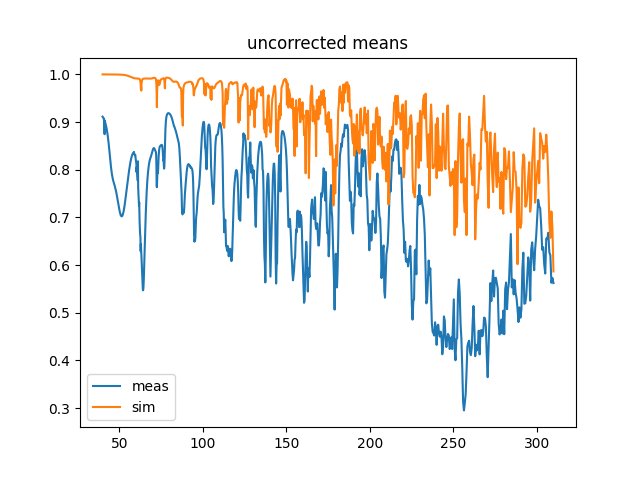

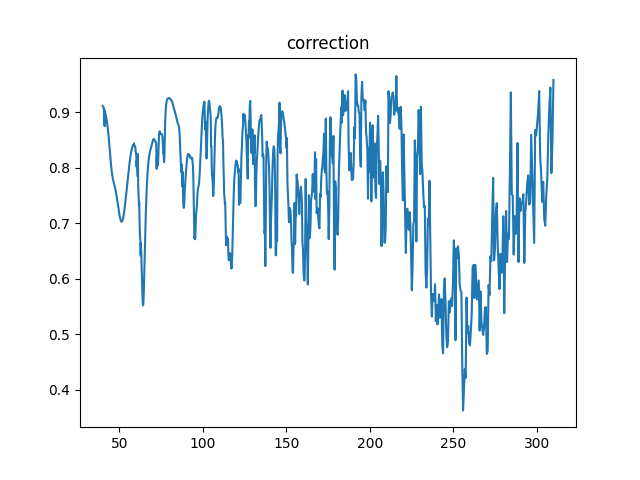

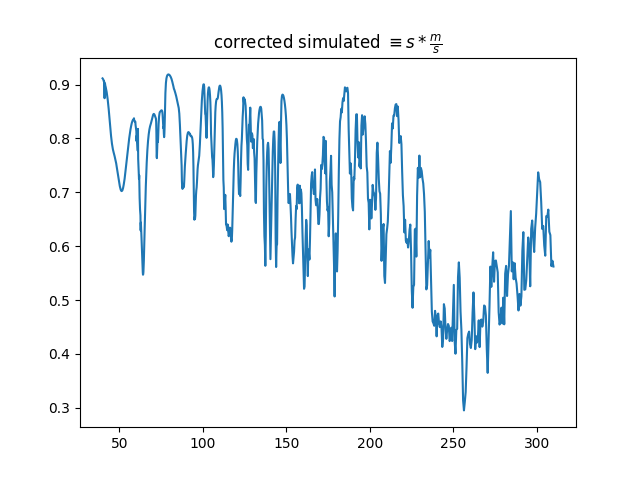

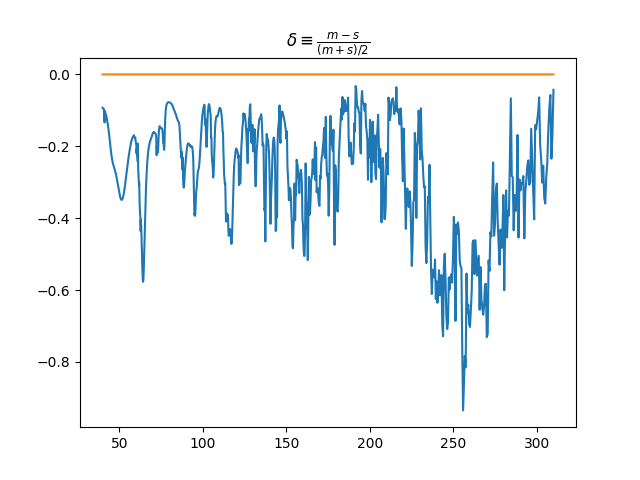

In [20]:
plt.close('all')

measured_mean_all   = df_meas.groupby('Frequency')['S11_Magnitude_Linear'].mean()
measured_freqs      = df_meas['Frequency'].unique()/1e6
simulated_mean_all  = df_comsol.groupby('freq(MHz)')['s11'].mean()
simulated_freqs     =df_comsol['freq(MHz)'].unique()

# Interpolate the simulated average onto the measured frequencies
measured_interpolated = np.interp(simulated_freqs, measured_freqs, measured_mean_all, )

plt.figure()
plt.title("uncorrected means")
plt.plot(simulated_freqs, measured_interpolated, label = 'meas')
plt.plot(simulated_freqs, simulated_mean_all, label = 'sim')
plt.legend()




correction = measured_interpolated/simulated_mean_all

plt.figure()
plt.title('correction')
plt.plot(correction)

plt.figure()
plt.title(r'corrected simulated $ \equiv s * \frac{m}{s}$')
plt.plot(simulated_freqs, simulated_mean_all*correction, label = 'meas')


plt.figure()
plt.title(r'$\delta \equiv \frac{m-s}{(m+s)/2}$')
plt.plot(simulated_freqs, (measured_interpolated-simulated_mean_all)/(1/2*(measured_interpolated+simulated_mean_all)), label = 'simulated')
plt.plot(simulated_freqs, (measured_interpolated-simulated_mean_all*correction)/(1/2*(measured_interpolated+simulated_mean_all*correction)), label = 'simulated, corrected')

In [17]:
###UNcorrected bootstrap

n_pos_avg = 9 #num antenna positions
delta_s11_samples = []
    
plt.close('all')
#plt.figure()

for i in range(1000):
    # Randomly select 9 positions from measured and simulated datasets
    measured_positions = np.random.choice(df_meas['Index'].unique(), n_pos_avg, replace=True)
    simulated_positions = np.random.choice(df_comsol['positionIdx'].unique(), n_pos_avg, replace=True)

    # Get all frequency points for the selected measured positions
    measured_sample = df_meas[df_meas['Index'].isin(measured_positions)]
    # Group by frequency and calculate mean S11_Magnitude for the measured data
    measured_mean = measured_sample.groupby('Frequency')['S11_Magnitude_Linear'].mean()

    #measured_mean.plot()

    # Get all frequency points for the selected simulated positions
    simulated_sample = df_comsol[df_comsol['positionIdx'].isin(simulated_positions)]
    # Group by frequency and calculate mean S11 for the simulated data
    

    simulated_mean = simulated_sample.groupby('freq(MHz)')['s11'].mean()

    # Interpolate the simulated average onto the measured frequencies
    simulated_freqs     = simulated_mean.index.values
    simulated_values    = simulated_mean.values
    measured_freqs      = (measured_mean.index.values)/1e6
    measured_values     = measured_mean.values
    measured_interpolated = np.interp(simulated_freqs, measured_freqs, measured_values, )

    if(0): # plot interpolation
        plt.title("Show interpolation")
        #plt.scatter(simulated_freqs, measured_interpolated)
        plt.plot(simulated_freqs, measured_interpolated, label = "interpolated measured data")
        #plt.scatter(measured_freqs, measured_mean)
        plt.plot(measured_freqs, measured_mean, label = "measured data")
        plt.legend()
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('S11 (linear)')


    # Compute delta S11
    delta_s11 = (simulated_values-measured_interpolated )/((simulated_values+measured_interpolated)/2)
    #delta_s11 = (measured_interpolated - simulated_values)
    delta_s11_samples.append(delta_s11)

    if(0): # plot measured, simulated and delta
        plt.plot(simulated_freqs, delta_s11)
        plt.plot(measured_freqs, measured_values)
        plt.plot(simulated_freqs, simulated_values)
        #delta_s11_samples.append(delta_s11)
# Convert list of arrays into a 2D numpy array
delta_s11_samples_array = np.vstack(delta_s11_samples)


Text(0, 0.5, '|S11| (linear)')

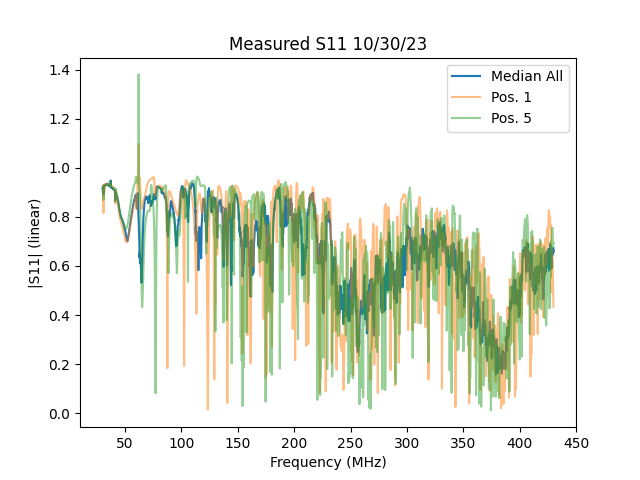

In [18]:
#compare single position to all for measured data


# Convert S11_Magnitude from dB to linear
#df_meas['S11_Magnitude_Linear'] = 10 ** (df_meas['S11_Magnitude'] / 20)


meadMeasData    = df_meas.groupby('Frequency')['S11_Magnitude_Linear'].median()
measData1  = df_meas.loc[df_meas['Index'] == 1 ] 
measData5  = df_meas.loc[df_meas['Index'] == 5 ] 

plt.close('all')
plt.figure()
plt.title('Measured S11 10/30/23')
plt.plot(measData1['Frequency']/1e6, (meadMeasData), label = 'Median All')
plt.plot(measData1['Frequency']/1e6, 10**(measData1['S11_Magnitude']/20), alpha = .5, label = 'Pos. 1')
plt.plot(measData5['Frequency']/1e6, 10**(measData5['S11_Magnitude']/20), alpha = .5, label = 'Pos. 5')
plt.legend()
plt.xlabel('Frequency (MHz)')
plt.ylabel('|S11| (linear)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


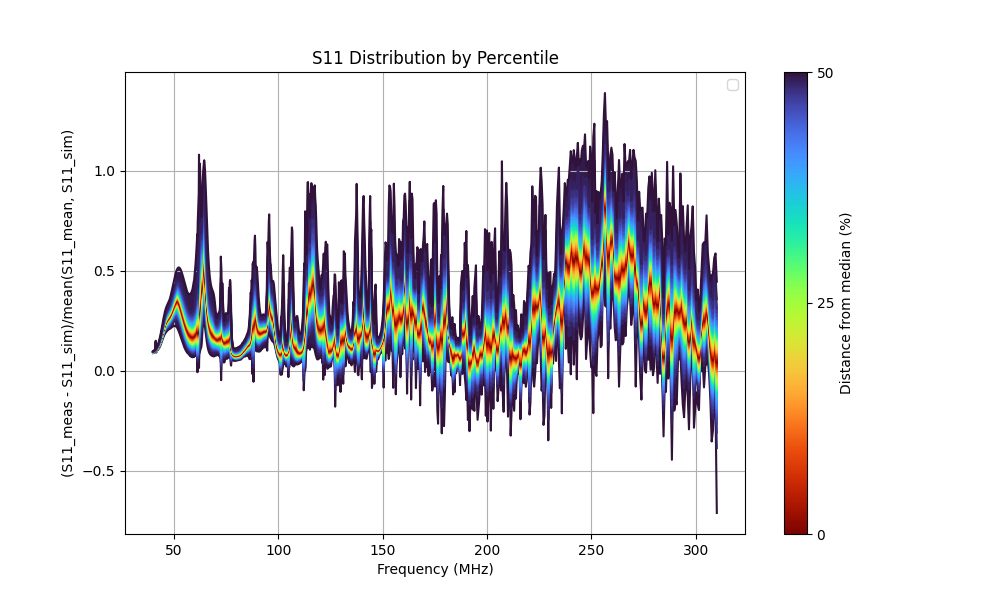

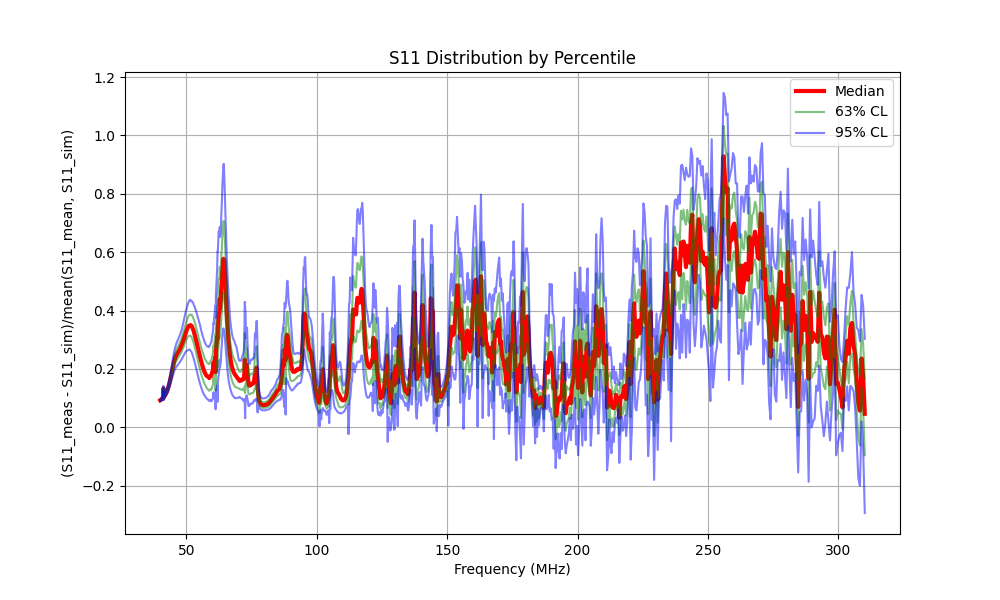

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
plt.close('all')

# Assuming delta_s11_samples_array is a numpy array where rows are bootstrap samples and columns are frequencies

# Define the range of percentiles to calculate
num_percentiles = 100
percentiles = np.linspace(0, 100, num=num_percentiles)

# Calculate the percentiles for each frequency
percentile_distribution = np.percentile(delta_s11_samples_array, percentiles, axis=0)

# Determine the colors for each percentile line based on its distance from the 50th percentile
colors = cm.turbo_r(np.abs(percentiles - 50) / 50.0)

# Plot each percentile line with the appropriate color and fill between them
plt.figure(figsize=(10, 6))
for i in range(len(percentiles) - 1):
    # Average color between the two percentile lines
    color_avg = (colors[i] + colors[i+1]) / 2
    plt.fill_between(simulated_freqs, percentile_distribution[i], percentile_distribution[i+1], color=color_avg, edgecolor=None)

# Overlay the lines on the fill for clarity
for i, p in enumerate(percentiles):
    plt.plot(simulated_freqs, percentile_distribution[i], color=colors[i])

# Create custom colorbar to reflect the distance from the median
sm = plt.cm.ScalarMappable(cmap=cm.turbo_r, norm=plt.Normalize(0, 50))
sm.set_array([])
cbar = plt.colorbar(sm, ticks=[0, 25, 50])
cbar.set_label('Distance from median (%)')

plt.xlabel('Frequency (MHz)')
plt.ylabel('(S11_meas - S11_sim)/mean(S11_mean, S11_sim)')
plt.title('S11 Distribution by Percentile')
#plt.plot(simulated_freqs,ci_lower, 'g--', linewidth = 2)
#plt.plot(simulated_freqs, ci_upper, 'g--', label = '95% CL', linewidth = 2)
plt.legend()
plt.grid(True)
plt.show()

##### only plot median and 95% #####

# Define the list of percentiles to calculate


# Calculate median
median_s11 = np.percentile(delta_s11_samples_array, 50 , axis=0)

# 63% s11
upper_63_s11 = np.percentile(delta_s11_samples_array, (100-63)/2 , axis=0)
lower_63_s11 = np.percentile(delta_s11_samples_array, 100-(100-63)/2 , axis=0)

# 95% s11
upper_95_s11 = np.percentile(delta_s11_samples_array, (100-95)/2 , axis=0)
lower_95_s11 = np.percentile(delta_s11_samples_array, 100-(100-95)/2 , axis=0)


plt.figure(figsize=(10, 6))

plt.xlabel('Frequency (MHz)')
plt.ylabel('(S11_meas - S11_sim)/mean(S11_mean, S11_sim)')
plt.title('S11 Distribution by Percentile')
plt.plot(simulated_freqs, median_s11, 'r', linewidth = 3, label = 'Median')
plt.plot(simulated_freqs, upper_63_s11, 'g', label = '63% CL', alpha = .5)
plt.plot(simulated_freqs, lower_63_s11, 'g', alpha = .5)
plt.plot(simulated_freqs, upper_95_s11,'b', label = '95% CL', alpha = .5)
plt.plot(simulated_freqs, lower_95_s11,'b', alpha = .5)
plt.legend()
plt.grid(True)
plt.show()




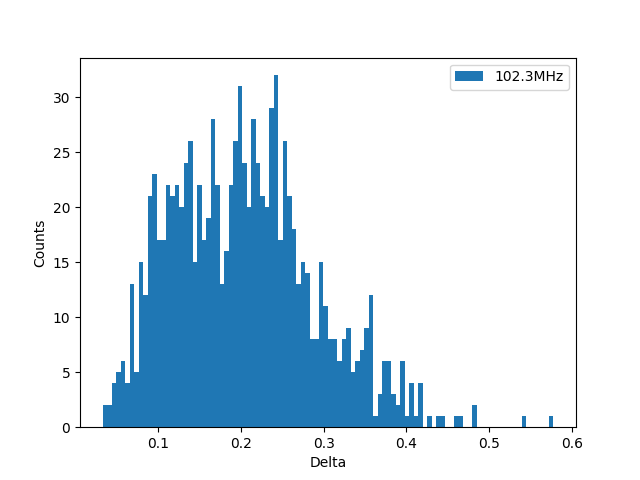

In [8]:
plt.close('all')
plt.figure()
plt.hist(delta_s11_samples_array[:,470], bins = 100, label=f'{round(simulated_freqs[470],2)}MHz')
#plt.hist(delta_s11_samples_array[:,674], bins = 100, label=f'{round(simulated_freqs[674],2)}MHz')
plt.xlabel('Delta')
plt.ylabel('Counts')
plt.legend()

In [24]:
#corrected bootstrap
#use correction on simulation
#AND square s11 stuff to make it m (for match)

n_pos_avg = 9 #num antenna positions
delta_M_samples = []
    
plt.close('all')
#plt.figure()

for i in range(1000):
    # Randomly select 9 positions from measured and simulated datasets
    measured_positions = np.random.choice(df_meas['Index'].unique(), n_pos_avg, replace=True)
    simulated_positions = np.random.choice(df_comsol['positionIdx'].unique(), n_pos_avg, replace=True)

    # Get all frequency points for the selected measured positions
    measured_sample = df_meas[df_meas['Index'].isin(measured_positions)]
    # Group by frequency and calculate mean S11_Magnitude for the measured data
    measured_mean = measured_sample.groupby('Frequency')['S11_Magnitude_Linear'].mean()

    #measured_mean.plot()

    # Get all frequency points for the selected simulated positions
    simulated_sample = df_comsol[df_comsol['positionIdx'].isin(simulated_positions)]
    # Group by frequency and calculate mean S11 for the simulated data

    #CORRECTED simulation!!!!!
    simulated_mean = simulated_sample.groupby('freq(MHz)')['s11'].mean()*correction
    

    # Interpolate the simulated average onto the measured frequencies
    simulated_freqs     = simulated_mean.index.values
    simulated_values    = simulated_mean.values
    measured_freqs      = (measured_mean.index.values)/1e6
    measured_values     = measured_mean.values
    measured_interpolated = np.interp(simulated_freqs, measured_freqs, measured_values, )

    if(0): # plot interpolation
        plt.title("Show interpolation")
        #plt.scatter(simulated_freqs, measured_interpolated)
        plt.plot(simulated_freqs, measured_interpolated, label = "interpolated measured data")
        #plt.scatter(measured_freqs, measured_mean)
        plt.plot(measured_freqs, measured_mean, label = "measured data")
        plt.legend()
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('S11 (linear)')


    # Compute delta M
    delta_M = (simulated_values**2-measured_interpolated**2)/((simulated_values**2+measured_interpolated**2)/2)
    delta_M_samples.append(delta_M)

    if(0): # plot measured, simulated and delta
        plt.plot(simulated_freqs, delta_s11)
        plt.plot(measured_freqs, measured_values)
        plt.plot(simulated_freqs, simulated_values)
        #delta_s11_samples.append(delta_s11)
# Convert list of arrays into a 2D numpy array
delta_M_samples_array = np.vstack(delta_M_samples)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


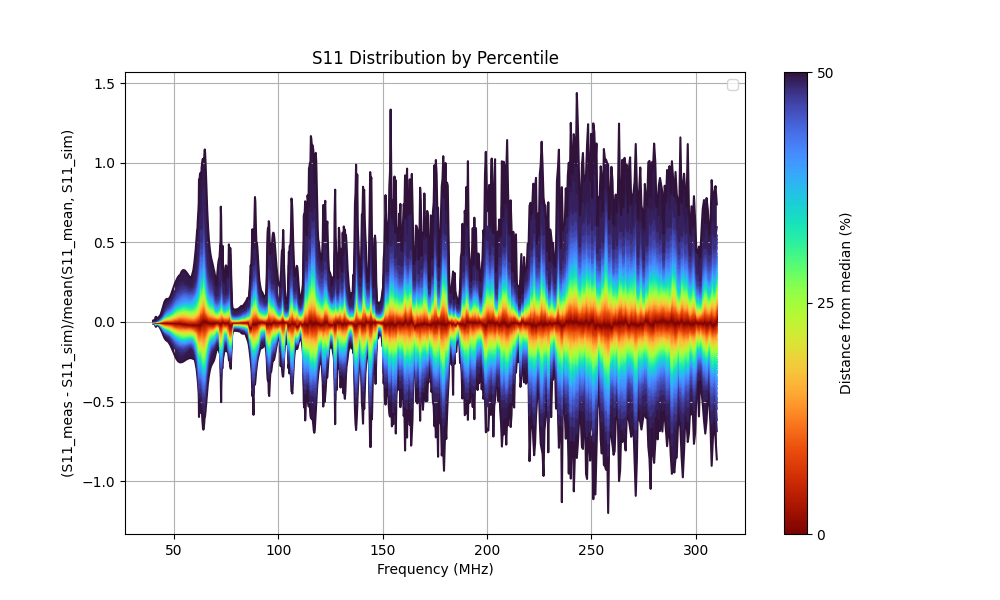

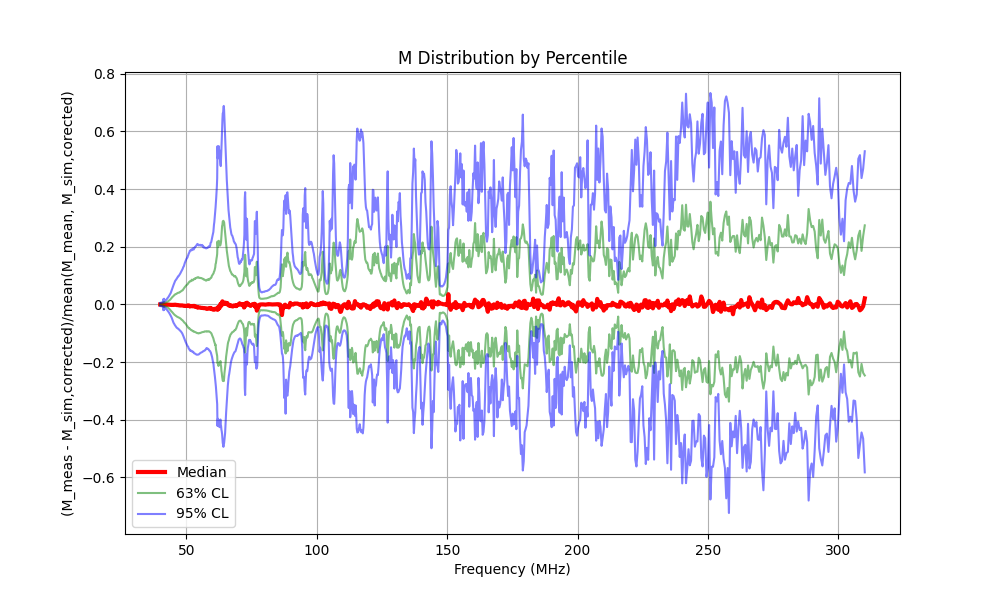

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
plt.close('all')

# Assuming delta_s11_samples_array is a numpy array where rows are bootstrap samples and columns are frequencies

# Define the range of percentiles to calculate
num_percentiles = 100
percentiles = np.linspace(0, 100, num=num_percentiles)

# Calculate the percentiles for each frequency
percentile_distribution = np.percentile(delta_M_samples_array, percentiles, axis=0)

# Determine the colors for each percentile line based on its distance from the 50th percentile
colors = cm.turbo_r(np.abs(percentiles - 50) / 50.0)

# Plot each percentile line with the appropriate color and fill between them
plt.figure(figsize=(10, 6))
for i in range(len(percentiles) - 1):
    # Average color between the two percentile lines
    color_avg = (colors[i] + colors[i+1]) / 2
    plt.fill_between(simulated_freqs, percentile_distribution[i], percentile_distribution[i+1], color=color_avg, edgecolor=None)

# Overlay the lines on the fill for clarity
for i, p in enumerate(percentiles):
    plt.plot(simulated_freqs, percentile_distribution[i], color=colors[i])

# Create custom colorbar to reflect the distance from the median
sm = plt.cm.ScalarMappable(cmap=cm.turbo_r, norm=plt.Normalize(0, 50))
sm.set_array([])
cbar = plt.colorbar(sm, ticks=[0, 25, 50])
cbar.set_label('Distance from median (%)')

plt.xlabel('Frequency (MHz)')
plt.ylabel('(S11_meas - S11_sim)/mean(S11_mean, S11_sim)')
plt.title('S11 Distribution by Percentile')
#plt.plot(simulated_freqs,ci_lower, 'g--', linewidth = 2)
#plt.plot(simulated_freqs, ci_upper, 'g--', label = '95% CL', linewidth = 2)
plt.legend()
plt.grid(True)
plt.show()

##### only plot median and 95% #####

# Define the list of percentiles to calculate


# Calculate median
median_M = np.percentile(delta_M_samples_array, 50 , axis=0)

# 63% s11
upper_63_M = np.percentile(delta_M_samples_array, (100-63)/2 , axis=0)
lower_63_M = np.percentile(delta_M_samples_array, 100-(100-63)/2 , axis=0)

# 95% s11
upper_95_M = np.percentile(delta_M_samples_array, (100-95)/2 , axis=0)
lower_95_M = np.percentile(delta_M_samples_array, 100-(100-95)/2 , axis=0)


plt.figure(figsize=(10, 6))

plt.xlabel('Frequency (MHz)')
plt.ylabel('(M_meas - M_sim,corrected)/mean(M_mean, M_sim,corected)')
plt.title('M Distribution by Percentile')
plt.plot(simulated_freqs, median_M, 'r', linewidth = 3, label = 'Median')
plt.plot(simulated_freqs, upper_63_M, 'g', label = '63% CL', alpha = .5)
plt.plot(simulated_freqs, lower_63_M, 'g', alpha = .5)
plt.plot(simulated_freqs, upper_95_M,'b', label = '95% CL', alpha = .5)
plt.plot(simulated_freqs, lower_95_M,'b', alpha = .5)
plt.legend()
plt.grid(True)
plt.show()




AttributeError: module 'matplotlib.pyplot' has no attribute 'yla'

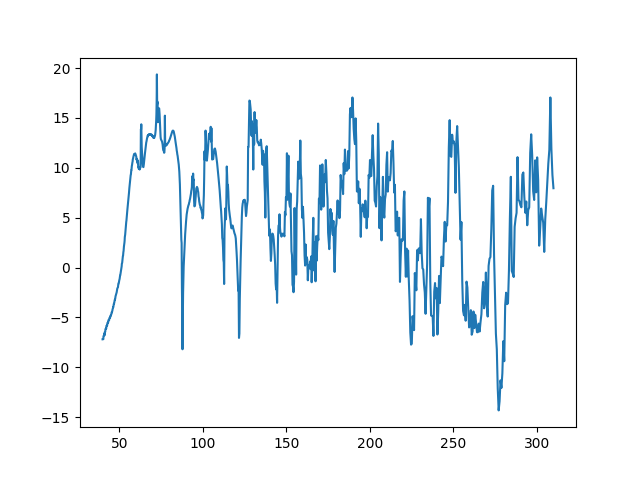

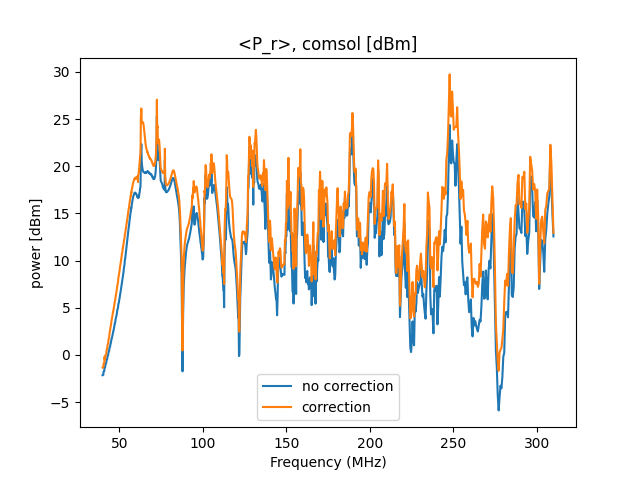

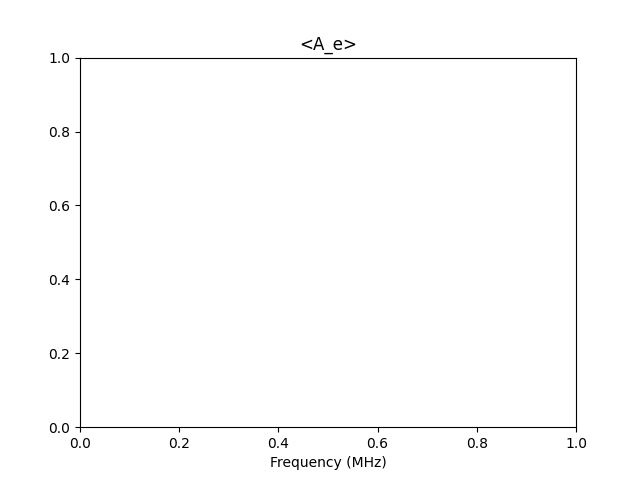

In [38]:
###Compute <A_e>
###Hill plane wave: <P_r> = E_0^2/377 Ohms * <A_e> 
# so, <A_e> =        <P_r>            / (E_0^2/377 Ohms)
#           =  (LPV_comsol^2/50 Ohms) / (E_0^2/377 Ohms) 
#BULLSHIT alert! to correct LPV_comsol, multiply by correction^2 (where correction is defined above) 

#           = (LPV_comsol^2/50 Ohms)* correction^2 / (E_0^2/377 Ohms) 


A_eAvg      = (df_comsol.groupby('freq(MHz)').mean()['LPV']**2 /50)*correction**2 / (1**2/377)
#print(df_comsol.groupby('freq(MHz)').mean()['LPV'])

plt.close('all')
plt.figure()
plt.plot(10*np.log10(A_eAvg))


plt.figure()
plt.title('<P_r>, comsol [dBm]')
plt.xlabel('Frequency (MHz)')
plt.ylabel('power [dBm]')
plt.plot(10*np.log10(1000*df_comsol.groupby('freq(MHz)').mean()['LPV']**2 /50), label ='no correction')
plt.plot(10*np.log10(1000*df_comsol.groupby('freq(MHz)').mean()['LPV']**2 /50/correction**2), label =  'correction')
plt.legend()

plt.figure()
plt.title(r'<A_e>')
plt.xlabel('Frequency (MHz)')
plt.ylabel()
plt.plot(simulated_freqs, A_eAvg)
plt.fill_between(simulated_freqs, (upper_63_M+1)*A_eAvg, (lower_63_M+1)*A_eAvg, alpha = 0.5, color = 'orange', label = r'1 $\sigma$ error bars')
plt.semilogy()
plt.legend()

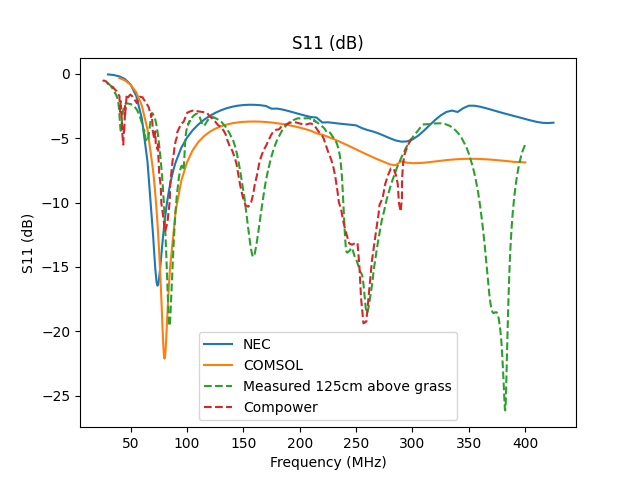

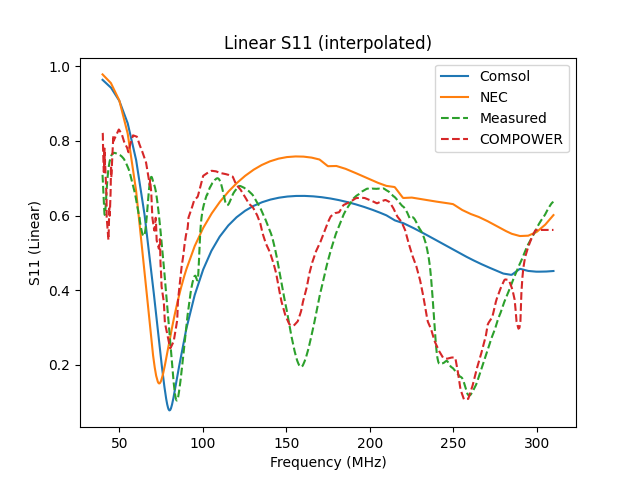

In [49]:
#Compare free space
plt.close('all')

comsol_freqs, comsol_VSWR = np.loadtxt('./biconFreeSpace_AF_data/VSWR_50Ohms_11_14_23.txt', skiprows=5, unpack=True)
comsol_s11 = 20*np.log10((comsol_VSWR-1)/(comsol_VSWR+1))
comsol_s11_lin = (comsol_VSWR-1)/(comsol_VSWR+1)

meas_outside_df                         = pd.read_csv('./biconFreeSpace_AF_data/Bicon-V125-outside_amin_11_13_23.csv')
meas_outside_freqs                      = meas_outside_df['Frequency']/1e6
meas_outside_s11                        = meas_outside_df['S11_Magnitude']
meas_outside_s11_lin                    = 10**(meas_outside_df['S11_Magnitude']/20)

###chatGPT to combine all the different resolutions (cleaning up after Amin)
NEC_df                                  = pd.read_csv('./biconFreeSpace_AF_data/bicon_freespace_NEC_amin_11_13_23.csv')
df1         = NEC_df[['Frequency (MHz)', 'VSWR (Bicon - free space)']].rename(columns={'Frequency (MHz)': 'Frequency', 'VSWR (Bicon - free space)': 'VSWR'})
df2         = NEC_df[['Frequency(MHz)', 'VSWR(1MHz resolution)']].rename(columns={'Frequency(MHz)': 'Frequency', 'VSWR(1MHz resolution)': 'VSWR'})
df3         = NEC_df[['Frequency(MHz).1', 'VSWR(0.1MHz resolution)']].rename(columns={'Frequency(MHz).1': 'Frequency', 'VSWR(0.1MHz resolution)': 'VSWR'})
df1         = df1.dropna()
df2         = df2.dropna()
df3         = df3.dropna()
combined_df = pd.concat([df1, df2, df3])
NEC_df      = combined_df.sort_values(by='Frequency').reset_index(drop=True)
NEC_freqs   = NEC_df['Frequency']
NEC_s11     =  20*np.log10((NEC_df['VSWR'].values-1)/(NEC_df['VSWR'].values+1))
NEC_s11_lin = (NEC_df['VSWR'].values-1)/(NEC_df['VSWR'].values+1)

compower_df                         = pd.read_csv('./biconFreeSpace_AF_data/COMPOWER_VSWR.csv')
compower_freqs                      = compower_df['Frequency(MHz)'].values
compower_s11                        = 20*np.log10((compower_df['VSWR'].values-1)/(compower_df['VSWR'].values+1))
compower_s11_lin                    = (compower_df['VSWR'].values-1)/(compower_df['VSWR'].values+1)

#interpolate everyting to the comsol in room simulation frequencies
comsol_s11_interp= np.interp(simulated_freqs, comsol_freqs, comsol_s11_lin)
meas_s11_interp= np.interp(simulated_freqs, meas_outside_freqs, meas_outside_s11_lin)
NEC_s11_interp= np.interp(simulated_freqs, NEC_freqs, NEC_s11_lin)
compower_s11_interp= np.interp(simulated_freqs, compower_freqs, compower_s11_lin)


plt.figure()
plt.title('S11 (dB)')
plt.plot(NEC_freqs,NEC_s11, label = 'NEC')
plt.plot(comsol_freqs, comsol_s11, label = 'COMSOL')
plt.plot(meas_outside_freqs, meas_outside_s11, '--', label = 'Measured 125cm above grass')
plt.plot(compower_freqs, compower_s11, '--', label = 'Compower')
plt.legend()
plt.xlabel('Frequency (MHz)')
plt.ylabel('S11 (dB)')


plt.figure()
plt.title('Linear S11 (interpolated)')
plt.plot(simulated_freqs, comsol_s11_interp, label = 'Comsol')
plt.plot(simulated_freqs, NEC_s11_interp, label = 'NEC' )
plt.plot(simulated_freqs, meas_s11_interp,'--', label = 'Measured')
plt.plot(simulated_freqs, compower_s11_interp,'--',label = 'COMPOWER')
plt.xlabel('Frequency (MHz)')
plt.ylabel('S11 (Linear)')
plt.legend()


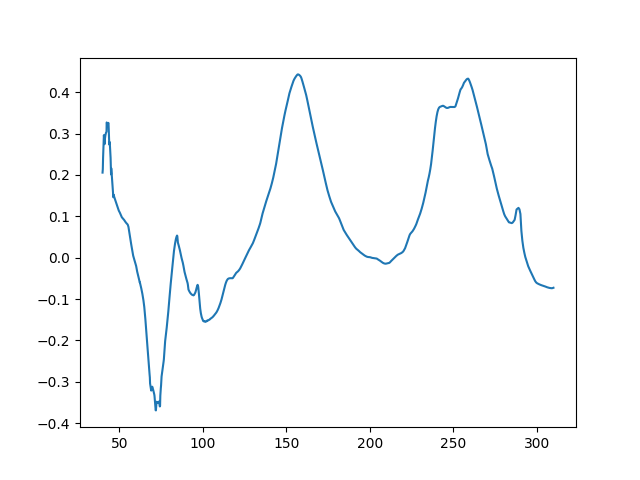

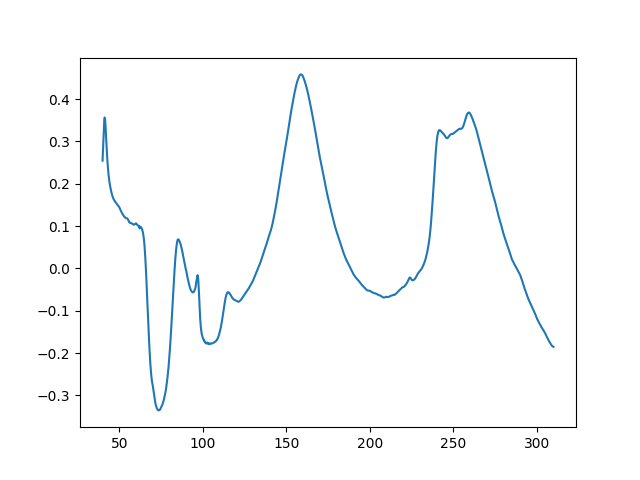

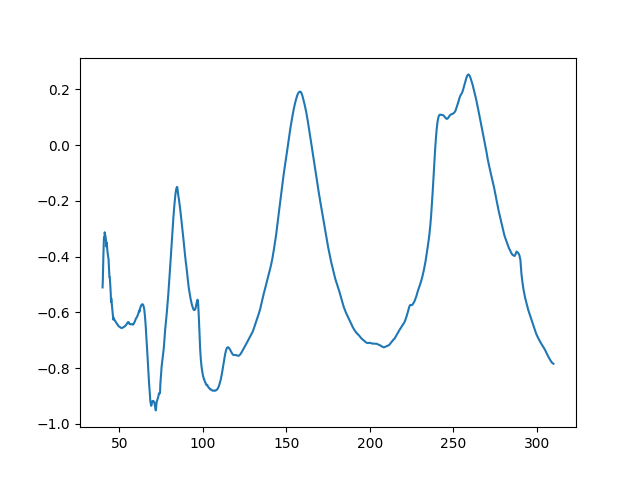

In [12]:
plt.close('all')
plt.figure()
plt.plot(simulated_freqs, ((NEC_s11_interp + comsol_s11_interp)/2) - (meas_s11_interp + compower_s11_interp)/2)

plt.figure()
plt.plot(simulated_freqs, (comsol_s11_interp - meas_s11_interp))

plt.figure()
plt.plot(simulated_freqs, ((comsol_s11_interp - meas_s11_interp)) - (meas_s11_interp + compower_s11_interp)/2)

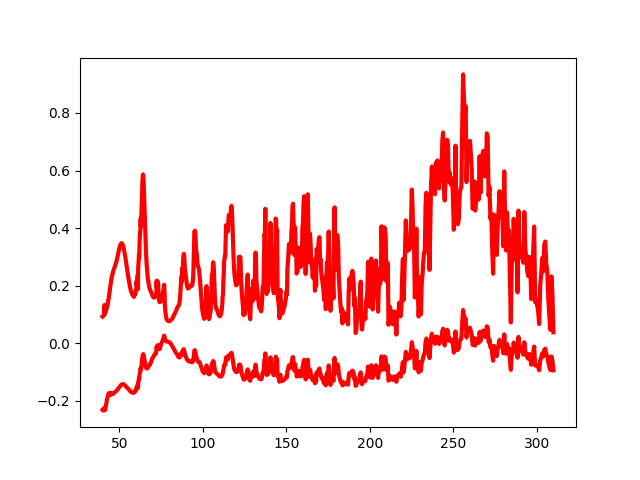

In [13]:
plt.close('all')
correctedMedian =  median_s11-((comsol_s11_interp - meas_s11_interp)) - (meas_s11_interp + compower_s11_interp)/2
plt.plot(simulated_freqs,correctedMedian*.25, 'r', linewidth = 3, label = 'Median')
plt.plot(simulated_freqs,median_s11, 'r', linewidth = 3, label = 'Median')